In [1]:
import numpy as np
import pandas as pd
import random
from EMDPM.model_generator import generate_logistic_model
from EMDPM.synthetic_data_generator import generate_synthetic_data
from EMDPM.visualization import (
    plot_biomarker_trajectories,
    plot_true_observations,
    plot_initial_beta_guess,
    plot_theta_fit_comparison,
    plot_theta_error_history,
    plot_beta_overlay,
    plot_beta_error_history,
    plot_lse,
    plot_cog_regression_history
)
from EMDPM.utils import solve_system
from EMDPM.em_transformer_rework import EM


true x0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true f: [0.         0.01123988 0.01207819 0.01155182 0.02688619 0.
 0.01019029 0.         0.         0.        ]
a = 1.8531667261047913, b = 1.5312904682995265


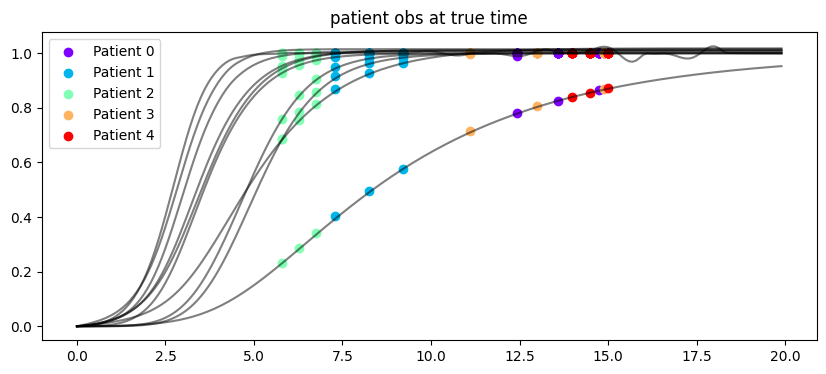

(600, 10) (600,) (600,) (600,) (600,)


In [2]:
# params
n_biomarkers = 10
t_max = 20
t_span = np.linspace(0, t_max, 8000)
noise_level = 0.0
n_patients = 200
n_patient_obs = 3

# fit and transform
t, x_true, K, x0, f, scalar_K  = generate_logistic_model(n_biomarkers=n_biomarkers, t_max=t_max)

df, cog_a, cog_b = generate_synthetic_data(
    n_biomarkers = n_biomarkers,
    t_max = t_max, 
    noise_level = noise_level,
    n_patients = n_patients,
    n_patient_obs = n_patient_obs,
    x_true=x_true, 
    t=t,
)
#plot_biomarker_trajectories(t, x_true, n_biomarkers=n_biomarkers)
plot_true_observations(df, t, x_true)

biomarker_cols = [col for col in df.columns if col.startswith("biomarker_")]

X = df[biomarker_cols].values       # (n_obs, n_biomarkers)
dt = df["dt"].values                # (n_obs,)
ids = df["patient_id"].values       # (n_obs,)
cog = df["cognitive_score"].values  # (n_obs,)
beta_true = df["beta_true"].values 

print(X.shape, dt.shape, ids.shape, cog.shape, beta_true.shape)

In [4]:
em_model_0 = EM(num_iterations=50, t_max=t_max, step=0.01,
                use_jacobian=True, lambda_cog=0.0, lambda_f=0.01, lambda_scalar=0.0)
em_model_0.fit(X=X, dt=dt, ids=ids, cog=cog, K=K)

initial conditions:
n_patients: 200, n_obs: 600
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
initial s: [1.29863068 2.48683136 0.16573133 0.5031427  2.95964328 2.98186855
 2.48212827 2.54551839 1.26382145 2.03467892]
initial scalar K: 1.0
initial beta: (200,)
prepend complete


  4%|▍         | 2/50 [00:04<01:58,  2.47s/it]

  6%|▌         | 3/50 [00:35<12:10, 15.54s/it]

  8%|▊         | 4/50 [00:36<07:31,  9.81s/it]

 10%|█         | 5/50 [00:57<10:13, 13.62s/it]

 12%|█▏        | 6/50 [00:59<07:16,  9.92s/it]

 14%|█▍        | 7/50 [01:09<06:54,  9.65s/it]

 16%|█▌        | 8/50 [01:10<04:57,  7.09s/it]

 18%|█▊        | 9/50 [01:17<04:45,  6.97s/it]

 20%|██        | 10/50 [01:19<03:34,  5.36s/it]

 22%|██▏       | 11/50 [01:26<03:47,  5.84s/it]

 24%|██▍       | 12/50 [01:27<02:55,  4.61s/it]

 26%|██▌       | 13/50 [01:37<03:50,  6.22s/it]

 28%|██▊       | 14/50 [01:39<02:52,  4.80s/it]

 30%|███       | 15/50 [01:51<04:01,  6.90s/it]

 32%|███▏      | 16/50 [01:52<02:55,  5.17s/it]

 34%|███▍      | 17/50 [02:09<04:54,  8.92s/it]

 36%|███▌      | 18/50 [02:10<03:30,  6.57s/it]

 38%|███▊      | 19/50 [02:23<04:22,  8.47s/it]

 40%|████      | 20/50 [02:26<03:17,  6.60s/it]

 42%|████▏     | 21/50 [02:38<03:58,  8.23s/it]

 44%|████▍     | 22/50 [02:38<02:48,  6.01s/it]

 46%|████▌     | 23/50 [02:57<04:25,  9.84s/it]

 48%|████▊     | 24/50 [02:58<03:05,  7.14s/it]

 50%|█████     | 25/50 [03:31<06:14, 14.99s/it]

 52%|█████▏    | 26/50 [03:32<04:16, 10.69s/it]

 54%|█████▍    | 27/50 [03:46<04:31, 11.79s/it]

 56%|█████▌    | 28/50 [03:47<03:08,  8.55s/it]

 58%|█████▊    | 29/50 [04:02<03:38, 10.41s/it]

 60%|██████    | 30/50 [04:03<02:29,  7.46s/it]

 62%|██████▏   | 31/50 [04:13<02:35,  8.18s/it]

 64%|██████▍   | 32/50 [04:13<01:46,  5.90s/it]

 66%|██████▌   | 33/50 [04:19<01:42,  6.02s/it]

 68%|██████▊   | 34/50 [04:20<01:10,  4.41s/it]

 70%|███████   | 35/50 [04:26<01:12,  4.82s/it]

 72%|███████▏  | 36/50 [04:26<00:50,  3.57s/it]

 74%|███████▍  | 37/50 [04:33<00:58,  4.47s/it]

 76%|███████▌  | 38/50 [04:34<00:41,  3.45s/it]

 78%|███████▊  | 39/50 [04:39<00:42,  3.82s/it]

 80%|████████  | 40/50 [04:40<00:28,  2.89s/it]

 82%|████████▏ | 41/50 [04:44<00:30,  3.42s/it]

 84%|████████▍ | 42/50 [04:45<00:21,  2.71s/it]

 86%|████████▌ | 43/50 [04:51<00:26,  3.77s/it]

 88%|████████▊ | 44/50 [04:53<00:17,  2.96s/it]

 90%|█████████ | 45/50 [04:59<00:20,  4.01s/it]

 92%|█████████▏| 46/50 [05:00<00:12,  3.05s/it]

 94%|█████████▍| 47/50 [05:05<00:11,  3.68s/it]

 96%|█████████▌| 48/50 [05:06<00:05,  2.90s/it]

 98%|█████████▊| 49/50 [05:11<00:03,  3.47s/it]

100%|██████████| 50/50 [05:12<00:00,  6.24s/it]


SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [6.99219626e-04 1.44763001e-02 1.88411872e-02 1.82081936e-02
 4.29615521e-02 8.00764912e-03 1.72357556e-02 1.32219352e-03
 1.21055446e-16 1.13659445e-16]


EM(lambda_cog=0.0, rng=Generator(PCG64) at 0x7F4E87CAF840, t_max=20)

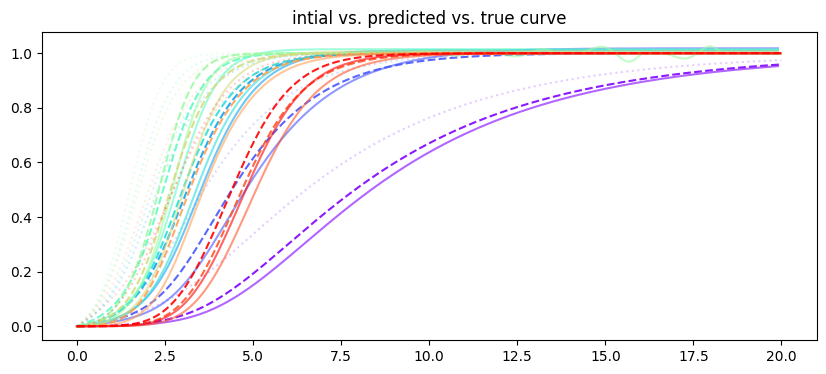

In [6]:
f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

#plot_initial_beta_guess(df, em_model_0.beta_iter_, t, x_true)
# histories
theta_history = em_model_0.theta_history
beta_history = em_model_0.beta_history
lse_history = em_model_0.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

# initial parameters
initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]

scaled_final_model = np.zeros_like(final_model)
for idx, s in enumerate(final_s):
    scaled_final_model[idx, :] = s * final_model[idx, :]

initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

# plotting
plot_theta_fit_comparison(t, t_span, x_true, initial_model, final_model, n_biomarkers)
#plot_beta_overlay(df, beta_iter=, em_model_0.theta_iter_, t_span, n_biomarkers, x_init, x_final, iteration=em_model_0.num_iterations - 1)
#plot_beta_error_history(beta_history, em_model_0.num_iterations)
#plot_lse(lse_history)
#plot_cog_regression_history(em_model_0.cog_regression_history_)



In [7]:
print("THETA SUMMARY:")
print("true theta:")
print("f: ", np.round(f_true, 3))
print("s: ", np.round(s_true, 3))
print("s_k: ", scalar_K_true)

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3))
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3))
print("s_k: ", final_theta[-1])

## Beta comparison:
print("\nBETA SUMMARY:")
beta_true = beta_true[::3]
print("beta true: ",np.round(beta_true,3))
print("beta final: ", np.round(beta_history[0:10,-1], 3))

THETA SUMMARY:
true theta:
f:  [0.    0.011 0.012 0.012 0.027 0.    0.01  0.    0.    0.   ]
s:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
s_k:  1.0
final theta:
f:  [0.001 0.014 0.019 0.018 0.043 0.008 0.017 0.001 0.    0.   ]
s:  [0.985 1.007 1.002 1.002 1.001 0.997 1.001 0.999 0.998 0.999]
s_k:  1.0198836643336544

BETA SUMMARY:
beta true:  [12.442  7.301  5.794 11.114 13.978  6.017  0.608  5.207  5.763  6.512
 15.966  5.926  2.145  0.315 12.133 17.218 10.719 16.757 11.055  1.898
  3.309  3.383  2.719  4.915  9.419 16.774 10.892  5.143 13.208  3.251
  9.468  1.945  9.279  7.104  6.586  0.357  5.304 11.513 12.797  1.921
 11.647  7.326  9.165  4.899 13.484  2.337 14.744 13.439  7.974 13.958
  1.998 12.721 16.224  9.168 15.469  6.256  8.245  2.805 12.048  2.088
 11.711 10.384 17.753  8.512  4.421  5.016 11.883  9.541 18.42   5.525
  5.482 11.43   8.565  8.567  7.138  0.498 14.369  8.645 11.934  2.621
  5.689  6.087 15.587 14.077  7.763  2.056  7.529  0.525 15.543  6.105
  7.348  6.055 10.387  0.

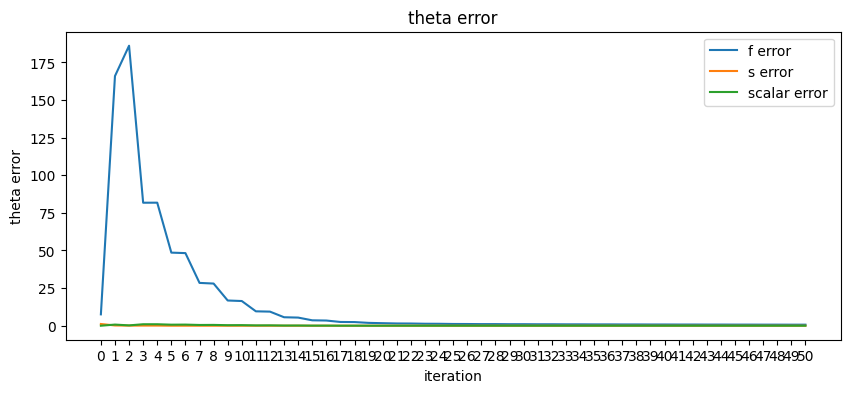

In [16]:
import matplotlib.pyplot as plt

def plot_theta_error_history(theta_history: np.ndarray, n_biomarkers: int,
                             f_true: np.ndarray, s_true: np.ndarray, scalar_K_true: float) -> None:
    """
    Plots normalized error of each parameter group over EM iterations.
    """
    num_iterations = theta_history.shape[1]
    f_error_history = []
    s_error_history = []
    scalar_K_error_history = []

    for iteration in range(num_iterations):
        theta = theta_history[:,iteration]

        f_est = theta[0:n_biomarkers]
        s_est = theta[n_biomarkers:2*n_biomarkers]
        scalar_K_est = theta[-1]

        f_err = np.mean(np.abs(f_true - f_est)) / (np.mean(np.abs(f_true)) + 1e-8)
        s_err = np.mean(np.abs(s_true - s_est)) / (np.mean(np.abs(s_true)) + 1e-8)
        k_err = np.abs(scalar_K_true - scalar_K_est) / (np.abs(scalar_K_true) + 1e-8)

        f_error_history.append(f_err)
        s_error_history.append(s_err)
        scalar_K_error_history.append(k_err)
        
    plt.figure(figsize=(10, 4))
    plt.plot(f_error_history, label="f error")
    plt.plot(s_error_history, label="s error")
    plt.plot(scalar_K_error_history, label="scalar error")
    plt.xticks(range(0,num_iterations))
    plt.title("theta error")
    plt.xlabel("iteration")
    plt.ylabel("theta error")
    plt.legend()
    plt.show()
    
plot_theta_error_history(theta_history=theta_history, n_biomarkers=n_biomarkers,
                         f_true=f, s_true=np.ones(n_biomarkers), scalar_K_true=scalar_K)

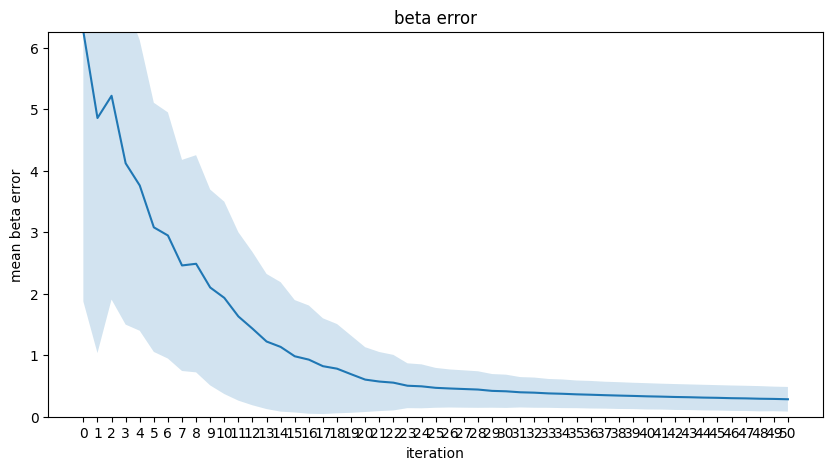

In [17]:
def plot_beta_error_history(beta_history: np.ndarray, beta_true: np.ndarray) -> None:
    """
    Plots mean beta estimation error over EM iterations.
    """
    num_iterations = beta_history.shape[1]
    beta_error_mean_history = np.zeros(num_iterations)
    beta_error_std_history = np.zeros(num_iterations)
    for iteration in range(num_iterations):
        beta_estimated = beta_history[:, iteration]    
        beta_error = np.abs(beta_estimated - beta_true)
        beta_error_mean_history[iteration] = np.mean(beta_error)
        beta_error_std_history[iteration] = np.std(beta_error)

    plt.figure(figsize=(10, 5))
    plt.plot(range(len(beta_error_mean_history)), beta_error_mean_history)
    plt.fill_between(range(len(beta_error_mean_history)),
                     beta_error_mean_history - beta_error_std_history,
                     beta_error_mean_history + beta_error_std_history,
                     alpha = 0.2)
    plt.ylim([0, max(beta_error_mean_history)])
    plt.xticks(range(0,num_iterations))
    plt.xlabel("iteration")
    plt.ylabel("mean beta error")
    plt.title("beta error")
    plt.show()

beta_true = df.groupby("patient_id")["beta_true"].first().values
plot_beta_error_history(beta_history, beta_true)

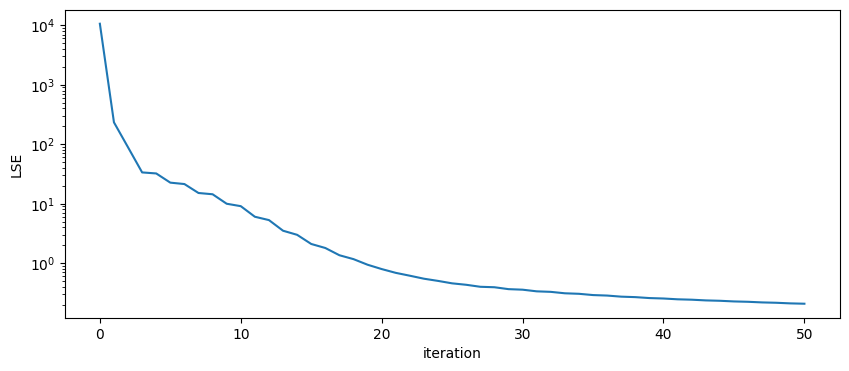

0.2079299236624817


In [18]:
plot_lse(lse_history)
print(lse_history[-1])

(2, 51)


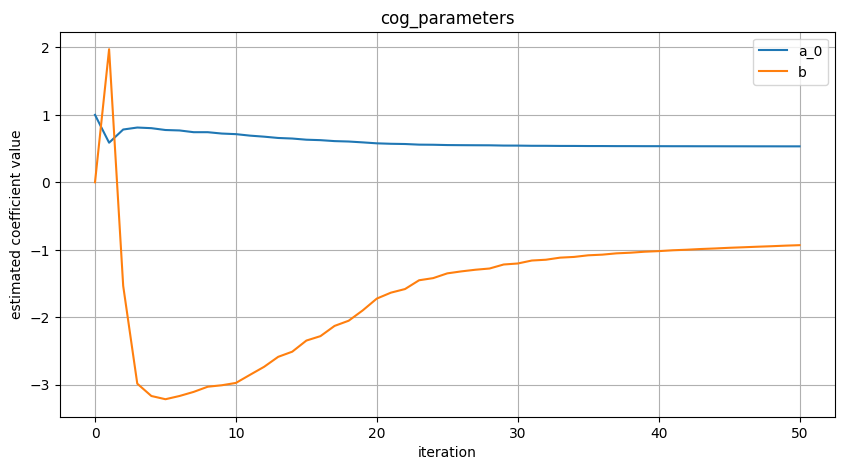

In [19]:
print(em_model_0.cog_regression_history.shape)

cog_true = np.array([cog_a, cog_b])
def plot_cog_regression_history(cog_history: np.ndarray, cog_true: np.ndarray):
    n_params, num_iterations = cog_history.shape
    
    # cog_error = np.zeros_like(cog_history)
    # for i in range(num_iterations):
    #     cog_error[:,i] = cog_error[:,i] - cog_true
    
    plt.figure(figsize=(10, 5))
    for i in range(n_params):
        label = f"a_{i}" if i < n_params - 1 else "b"
        plt.plot(range(num_iterations), cog_history[i,:], label=label)
    plt.legend()
    plt.xlabel("iteration")
    plt.ylabel("estimated coefficient value")
    plt.title("cog_parameters")
    plt.grid(True)
    plt.show()
    
plot_cog_regression_history(em_model_0.cog_regression_history, cog_true)

### lamda cog test

In [22]:
em_model_0 = EM(num_iterations=50, t_max=t_max, step=0.01,
                use_jacobian=True, lambda_cog=0.01, lamda=0.01)
em_model_0.fit(X=X, dt=dt, ids=ids, cog=cog, K=K)

initial conditions:
n_patients: 200, n_obs: 600
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
initial s: [1.29863068 2.48683136 0.16573133 0.5031427  2.95964328 2.98186855
 2.48212827 2.54551839 1.26382145 2.03467892]
initial scalar K: 1.0
initial beta: (200,)
prepend complete


  4%|▍         | 2/50 [00:03<01:26,  1.81s/it]

  6%|▌         | 3/50 [00:49<17:16, 22.05s/it]

  8%|▊         | 4/50 [00:52<10:58, 14.31s/it]

 14%|█▍        | 7/50 [02:18<21:34, 30.11s/it]

 16%|█▌        | 8/50 [02:21<14:52, 21.24s/it]

 18%|█▊        | 9/50 [02:52<16:37, 24.32s/it]

100%|██████████| 50/50 [03:31<00:00,  4.23s/it]


SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [1.62677702e-03 1.24621285e-01 3.56316855e-01 6.14152516e+00
 6.85435655e-01 8.17381833e-01 5.36308995e-01 3.49895853e-01
 1.05342278e-01 1.40906351e-01]


EM(lambda_cog=0.01, rng=Generator(PCG64) at 0x7F1CB74F09E0, t_max=20,
   use_jacobian=True)

THETA SUMMARY:
true theta:
f:  [0.    0.011 0.012 0.012 0.027 0.    0.01  0.    0.    0.   ]
s:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
s_k:  1.0
final theta:
f:  [2.000e-03 1.250e-01 3.560e-01 6.142e+00 6.850e-01 8.170e-01 5.360e-01
 3.500e-01 1.050e-01 1.410e-01]
s:  [2.655 1.018 0.998 0.921 1.001 0.996 1.002 0.995 1.019 1.003]
s_k:  0.11070621066413791

BETA SUMMARY:
beta true:  [12.442 11.114  0.608  6.512  2.145 17.218 11.055  3.383  9.419  5.143
  9.468  7.104  5.304  1.921  9.165  2.337  7.974 12.721 15.469  2.805
 11.711  8.512 11.883  5.525  8.565  0.498 11.934  6.087  7.763  0.525
  7.348  0.024  6.135 12.98  16.588  7.957  8.595 10.237 11.443  7.774
  8.371  3.357  8.837 14.221  9.753  7.475 15.943 17.044  9.13  11.425
 15.874  8.274 12.744  3.287  7.15   9.688  9.472  5.789 12.606 13.993
 11.989  3.882  7.391  7.185 10.957  0.043 12.597]
beta final:  [20.    14.467 10.541 19.865 20.    12.334  0.     9.152 13.632 13.803]


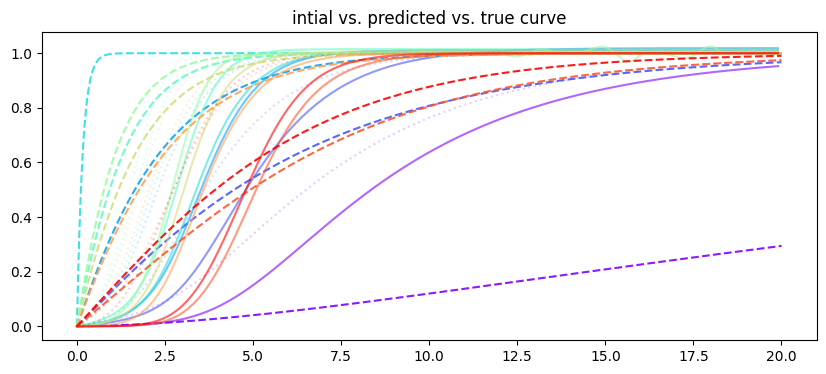

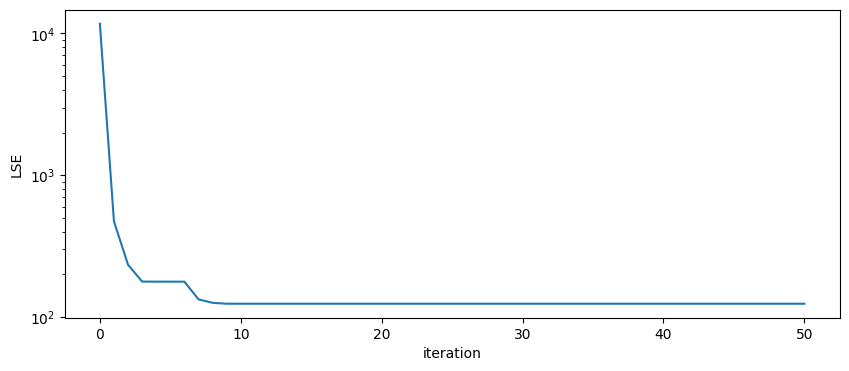

In [ ]:
f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

#plot_initial_beta_guess(df, em_model_0.beta_iter_, t, x_true)
# histories
theta_history = em_model_0.theta_history
beta_history = em_model_0.beta_history
lse_history = em_model_0.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

# initial parameters
initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]

scaled_final_model = np.zeros_like(final_model)
for idx, s in enumerate(final_s):
    scaled_final_model[idx, :] = s * final_model[idx, :]

initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("THETA SUMMARY:")
print("true theta:")
print("f: ", np.round(f_true, 3))
print("s: ", np.round(s_true, 3))
print("s_k: ", scalar_K_true)

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3))
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3))
print("s_k: ", final_theta[-1])

## Beta comparison:
print("\nBETA SUMMARY:")
beta_true = beta_true[::3]
print("beta true: ",np.round(beta_true,3))
print("beta final: ", np.round(beta_history[0:10,-1], 3))

# plotting
plot_theta_fit_comparison(t, t_span, x_true, initial_model, final_model, n_biomarkers)
plot_lse(lse_history)
#plot_beta_overlay(df, beta_iter=, em_model_0.theta_iter_, t_span, n_biomarkers, x_init, x_final, iteration=em_model_0.num_iterations - 1)
#plot_beta_error_history(beta_history, em_model_0.num_iterations)
#plot_lse(lse_history)
#plot_cog_regression_history(em_model_0.cog_regression_history_)

